**Steam Reviews Classification**

**Steam** is arguably the most relevant gaming platforms available online, attracting dozens of millions of users every month and offering more than 35,000 games through its store. Players can leave a review for any game they own, deciding to recommend it or not.

By working on a dataset which collects Steam reviews for eleven different games, available [here](https://github.com/mulhod/steam_reviews/tree/master), we are going to perform a binary classification task, building a model able to discriminate between "recommended" and "not recommended" ratings given to games based on the review written by the author. The statistical tool we will use is logistic regression.

In [1]:
import pandas as pd
import os
import json
import string

Let's start by importing our data from the files.

In [2]:
# data is in JSON Lines format, so we need a few steps in order to import it 

data_folder = os.path.join(os.getcwd(), "data")
data_files_names = os.listdir(data_folder)

data = []

for data_file_name in data_files_names:
    file = os.path.join(os.getcwd(), "data", data_file_name)
    with open(file, "r", encoding='utf-8') as f:
        lst = [json.loads(line) for line in f]
    data.extend(lst)

df = pd.DataFrame.from_records(data)

Let's see the first entry of the dataframe as an example:

In [3]:
df.head(1)

,total_game_hours_last_two_weeks,num_groups,orig_url,num_badges,review_url,num_found_funny,review,date_updated,num_workshop_items,date_posted,...,num_found_unhelpful,total_game_hours,username,num_guides,rating,num_friends,num_screenshots,num_comments,num_reviews,num_games_owned
0,58.7,NaN,http://steamcommunity.com/app/107410/homeconte...,NaN,http://steamcommunity.com/id/thisisthefallout/...,1,My first game on A3 brought me the most horrif...,"May 3, 2015, 2:28AM",0,"Oct 31, 2014, 7:00AM",...,253,580.3,King Pootis,0,Recommended,NaN,0,70,0,0


And this is the first review, along with the rating:

In [4]:
df[["review", "rating"]].values[0]

array(['My first game on A3 brought me the most horrific experience I\'ve ever had in any game, ever. We\'re on our way to the objective, a small dump east of a town occupied by enemy forces. I\'m leading a team of 4 men. We come to a crossroad and I sprint across, telling my men to hold back. I cross a few more times, trying to get a response from any snipers. Nothing. I run, my LMG gunner runs, my medic runs. But I kept my Marksman on the other side to make sure we\'d make it across. Anybody seen Full Metal Jacket all the way through? Remember the sniper scene? The marksman takes a round in the leg as we\'re running and goes down. He then takes two more in the chest. The kid who was playing had some mad acting skills, he played it up to 11 here. He screams as he\'s being shot. Crawling, drenched in his own blood. "SARGE? YOU AIN\'T LEAVING ME OUT HERE LIKE THIS, RIGHT? I-I WANNA GO WITH YOU GUYS! C\'MON SARGE, H-HELP ME! C\'MON! PLEASE DON\'T LEAVE ME!" he died after that. I cried an

Now that we have got the data, we need to perform some Natural Language Processing (NLP) on the reviews, so that we can manipulate them correctly.
We need to remove superfluous elements of the text, such as punctuation and stopwords, tokenize it and finally lemmatize the words, transforming them to their dictionary form (lemma).
These tasks can be accomplished through the NLTK (Natural Language Toolkit) library.

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [6]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
lemmatized_reviews = []

for review in df["review"]:
    review = review.translate(str.maketrans('', '', string.punctuation)).lower()
    words_in_review = word_tokenize(review)
    filtered_list = []
    for word in words_in_review:
        if word not in stop_words:
            filtered_list.append(word)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_list]
    lemmatized_reviews.append(" ".join(lemmatized_words))

df["lemmatized_reviews"] = lemmatized_reviews

Let's have a look at the first review after it has been lemmatized:

In [7]:
df["lemmatized_reviews"].values[0]

'first game a3 brought horrific experience ive ever game ever way objective small dump east town occupied enemy force im leading team 4 men come crossroad sprint across telling men hold back cross time trying get response sniper nothing run lmg gunner run medic run kept marksman side make sure wed make across anybody seen full metal jacket way remember sniper scene marksman take round leg running go take two chest kid playing mad acting skill played 11 scream he shot crawling drenched blood sarge aint leaving like right ii wan na go guy cmon sarge hhelp cmon please dont leave died cried respawned 1110 would recommend getting'

At this point, we are going to transform our text documents into vectors by using a vectorizer. Additionally, words will be weighted through the TF-IDF method, assuring that we are measuring the real importance of each word in our corpus.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["lemmatized_reviews"])
y = df["rating"]

Now we have got our regressor (the lemmatized reviews) in the form of a vector and the dependent variable as well.
We can split our data into a training set and a test set (with a ratio of 80% / 20%) and then creating our model.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
classifier = LogisticRegression()
classifier.fit(X_train, y_train);

Finally, we obtain the predicted values for the response variable and evaluate the accuracy of our model through a few measures.

In [12]:
y_pred = classifier.predict(X_test)

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:", accuracy)

Accuracy score: 0.9290659617321249


This number represents the ratio of successfully classified samples to the total samples available.
It's a value very close to 1, which means our model is pretty accurate in predicting the final rating given to a game based on the corresponding review.

We are concluding our analysis by calculating the **confusion matrix**: each element (i, j) of this matrix is the amount of times our model has classified the "true" class i as the class j. Therefore, starting from the top left corner and proceeding clockwise, we are going to get: true negatives, false positives, true positive, false negatives.

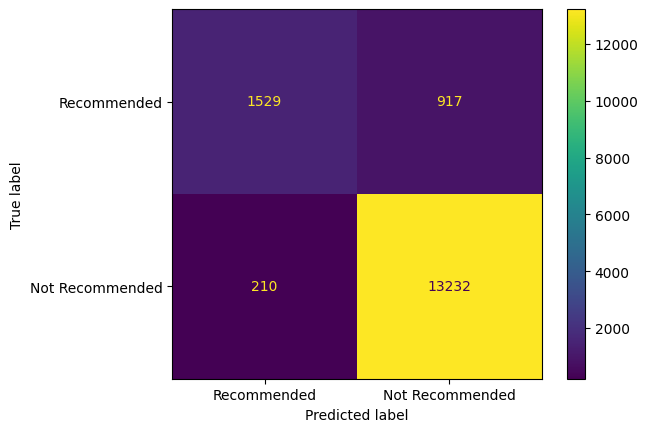

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = df["rating"].unique())
disp.plot()
plt.show()